In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.regularizers import l2

2023-11-17 14:10:34.393477: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 14:10:34.420581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 14:10:34.420612: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 14:10:34.420629: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 14:10:34.425229: I tensorflow/core/platform/cpu_feature_g

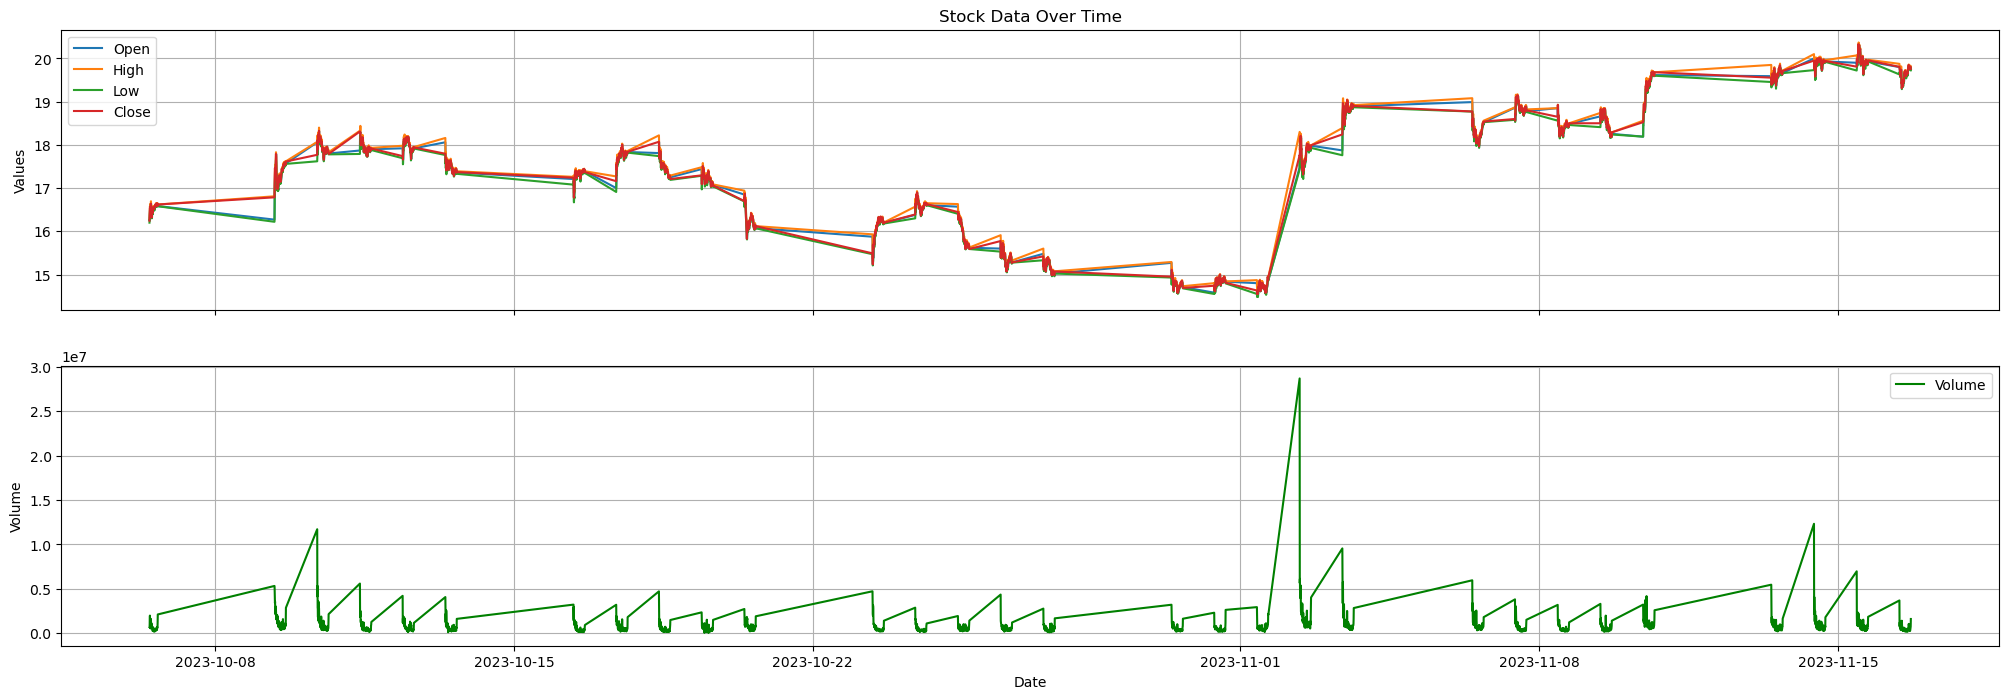

In [2]:
file_path = '../../data/PLTR_ta.csv'
target_column_name = 'Close'

pltr = pd.read_csv(file_path, index_col=0, parse_dates=True)
pltr.dropna(inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(25, 8), sharex=True)

ax[0].plot(pltr['Open'], label='Open')
ax[0].plot(pltr['High'], label='High')
ax[0].plot(pltr['Low'], label='Low')
ax[0].plot(pltr['Close'], label='Close')
# ax[0].plot(pltr['Adj Close'], label='Adj Close')
ax[0].set_title('Stock Data Over Time')
ax[0].set_ylabel('Values')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(pltr['Volume'], label='Volume', color='green')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume')
ax[1].legend()
ax[1].grid(True)

plt.show()

In [ ]:
pltr.columns

In [3]:
cols = [target_column_name] + [ col for col in pltr if col != target_column_name]
target_column = list(pltr.columns).index(target_column_name)
data = pltr[cols]

# Define feature array and target array to train the model.
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

# Split the data
train_size = int(len(data_array) * 0.80)

def create_sequences(data, target, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(target[i])
    return np.array(sequence_data), np.array(sequence_target)

SEQUENCE_LENGTH = 5
data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH)

train_data, test_data = data_sequences[:train_size], data_sequences[train_size:]
train_target, test_target = target_sequences[:train_size], target_sequences[train_size:]

############################################################################################################
# 
# SEQUENCE TEST:
#   compare the data with the one inside the csv: you will notice that:
#   - we are using 17 entries as input
#   - we are forecasting (target) the 18th entry of "target_column"
############################################################################################################

# test_index = -1
# a = scaler_data.inverse_transform(data_sequences[test_index])
# b = scaler_target.inverse_transform(target_sequences)

# print(f"Values for the [{test_index}] prediction:")
# for i in range (0, 17):
#     print(f"\tdata[{i}]: {a[i][0]}")

# print(f'\n\tprediction: {b[test_index]}')

## Correct

In [16]:
############################################################################################################
#
# Model Definition
#
############################################################################################################

def build_attention_model():
    """LSTM model"""
    inputs = keras.layers.Input(shape=(train_data.shape[1], train_data.shape[2]))
    lstm_out = keras.layers.LSTM(90, return_sequences=False, return_state=False) (inputs)
    attention = keras.layers.Attention() ([lstm_out, lstm_out])
    context_vector = keras.layers.Concatenate(axis=-1)([lstm_out, attention])
    output = keras.layers.Dense(units=50, activation='relu') (context_vector)
    output = keras.layers.Dense(1, activation='linear') (output)

    model = keras.models.Model(inputs=inputs, outputs=output)
    return model

def build_model():
    """LSTM model"""
    l2_value = 0.01
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(
        units=128,
        return_sequences=False,
        kernel_regularizer=l2(l2_value),
        recurrent_regularizer=l2(l2_value),
        bias_regularizer=l2(l2_value)
        ))
    model.add(keras.layers.Dense(units=20))
    model.add(keras.layers.Dense(units=1))
    return model

def build_parallel_model(input_shape, l2_value=0.01):
    # LSTM Branch
    lstm_input = keras.layers.Input(shape=input_shape)
    lstm_branch = keras.layers.LSTM(128, kernel_regularizer=l2(l2_value), recurrent_regularizer=l2(l2_value), bias_regularizer=l2(l2_value))(lstm_input)

    # Parallel Dense Branch
    dense_input = keras.layers.Input(shape=input_shape)
    flattened = keras.layers.Flatten()(dense_input)
    # dense_branch = keras.layers.Dense(64, activation='gelu')(flattened)
    dense_branch = keras.layers.Dense(32, activation='relu')(flattened)

    # Combining the branches
    combined = keras.layers.concatenate([lstm_branch, dense_branch])

    # Additional layers after combining
    combined_dense = keras.layers.Dense(10)(combined)
    output = keras.layers.Dense(1)(combined_dense)

    model = keras.models.Model(inputs=[lstm_input, dense_input], outputs=output)
    return model

def train_model(model, train_data, train_target, epochs=30, batch_size=256):
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=2,
        mode='min',
        restore_best_weights=True,
    )

    model.fit(
        [train_data, train_data],  # Assuming both branches use the same training data
        train_target,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_spli=0.2
        callbacks=[early_stopping]
    )

############################################################################################################
#
# Model Generation & Training
#
############################################################################################################
epochs = 1000
batch_size = 256

model = build_parallel_model(input_shape=(train_data.shape[1], train_data.shape[2]))
train_model(model, train_data, train_target, epochs=epochs, batch_size=batch_size)

Epoch 1/1000
6/6 - 1s - loss: 3.1171 - val_loss: 2.9592 - 1s/epoch - 236ms/step
Epoch 2/1000
6/6 - 0s - loss: 2.7194 - val_loss: 2.6743 - 42ms/epoch - 7ms/step
Epoch 3/1000
6/6 - 0s - loss: 2.4851 - val_loss: 2.3289 - 46ms/epoch - 8ms/step
Epoch 4/1000
6/6 - 0s - loss: 2.2639 - val_loss: 2.1481 - 39ms/epoch - 7ms/step
Epoch 5/1000
6/6 - 0s - loss: 2.0808 - val_loss: 2.0146 - 40ms/epoch - 7ms/step
Epoch 6/1000
6/6 - 0s - loss: 1.9341 - val_loss: 1.8537 - 41ms/epoch - 7ms/step
Epoch 7/1000
6/6 - 0s - loss: 1.8053 - val_loss: 1.7374 - 40ms/epoch - 7ms/step
Epoch 8/1000
6/6 - 0s - loss: 1.6972 - val_loss: 1.6481 - 40ms/epoch - 7ms/step
Epoch 9/1000
6/6 - 0s - loss: 1.6061 - val_loss: 1.5579 - 38ms/epoch - 6ms/step
Epoch 10/1000
6/6 - 0s - loss: 1.5276 - val_loss: 1.4865 - 43ms/epoch - 7ms/step
Epoch 11/1000
6/6 - 0s - loss: 1.4601 - val_loss: 1.4279 - 43ms/epoch - 7ms/step
Epoch 12/1000
6/6 - 0s - loss: 1.4016 - val_loss: 1.3711 - 46ms/epoch - 8ms/step
Epoch 13/1000
6/6 - 0s - loss: 1.3507

58/58 [==============================] - 0s 976us/step


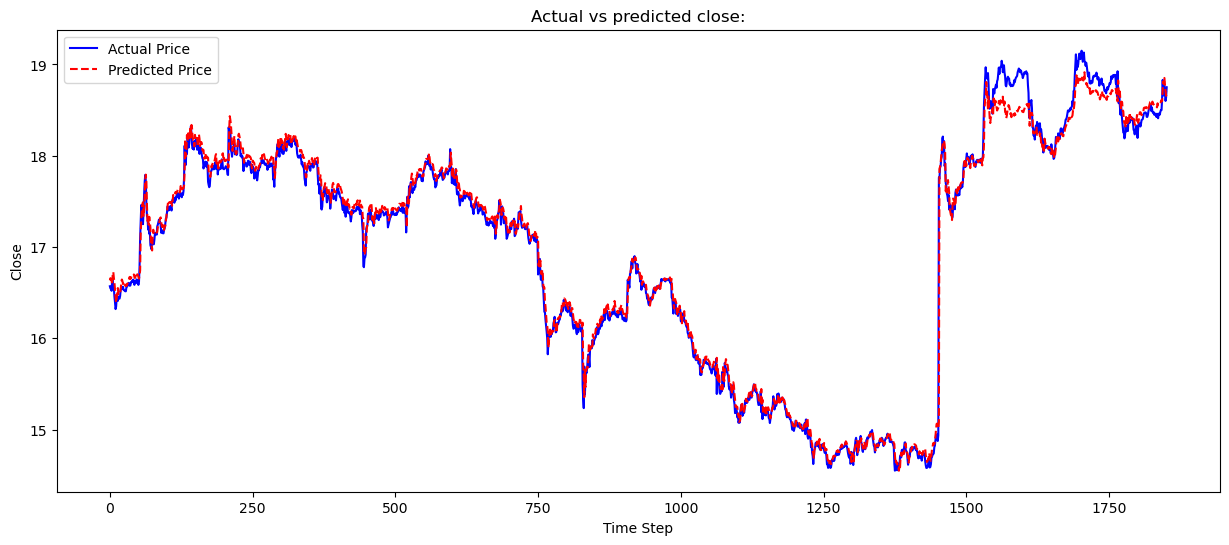

In [17]:
price_predicted_array = scaler_target.inverse_transform(model.predict([train_data, train_data]))
price_actual_array = scaler_target.inverse_transform(train_target).flatten()

plt.figure(figsize=(15, 6))
plt.plot(price_actual_array, label="Actual Price", color='blue')
plt.plot(price_predicted_array, label="Predicted Price", color='red', linestyle='dashed')
plt.title("Actual vs predicted close:")
plt.xlabel("Time Step")
plt.ylabel(target_column_name)
plt.legend()

plt.show()